In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.autolayout'] = False

In [2]:
# Config
pvalue_file = '../output/simulated_test/0.05_pct_afr-eur_vs_neand1_isf-0.0001_pvalues.txt'
output_dir = '../output/simulated_test/'

In [4]:
d = pd.read_csv(pvalue_file, sep='\t', dtype={"chr": "category", "haplotype": "category"})

In [5]:
introgressed_windows = d['overlap_informative_sites'] > 0
nonintrogressed_windows = ~introgressed_windows

In [6]:
# introgressed_hist, ibins = np.histogram(d[introgressed_windows]['pvalue'], bins=20)
# nonintrogressed_hist, nbins = np.histogram(d[nonintrogressed_windows]['pvalue'], bins=20)

# width = 0.7 * (ibins[1] - ibins[0])
# center = (ibins[:-1] + ibins[1:]) / 2
# plt.bar(center, introgressed_hist, align='center', width=width)

# width = 0.7 * (nbins[1] - nbins[0])
# center = (nbins[:-1] + nbins[1:]) / 2
# plt.bar(center, nonintrogressed_hist, align='center', width=width)

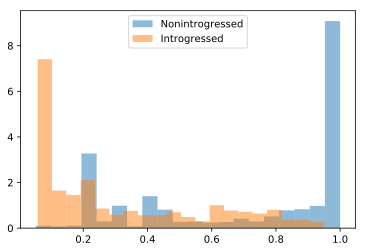

In [7]:
matplotlib.pyplot.hist(d[nonintrogressed_windows]['pvalue'], density=True, label='Nonintrogressed', alpha=0.5, bins=20)
matplotlib.pyplot.hist(d[introgressed_windows]['pvalue'], density=True, label='Introgressed', alpha=0.5, bins=20)
matplotlib.pyplot.legend(loc='upper center')
matplotlib.pyplot.show()

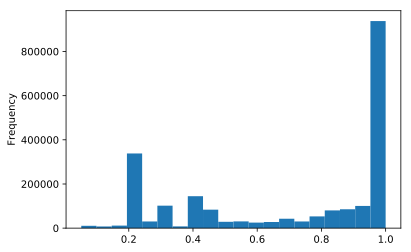

In [8]:
d[nonintrogressed_windows]['pvalue'].plot.hist(bins=20)

In [9]:
d[introgressed_windows]['pvalue'].plot.hist(bins=20)

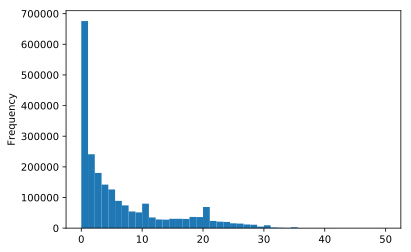

In [10]:
d['isfd'].plot.hist(bins=45)

In [11]:
# import plotly as py
# import plotly.graph_objs as go
# py.offline.init_notebook_mode(connected=True)

# data = [go.Histogram(x=d['pval'],
#                      nbinsx=45)]
# py.offline.iplot(data, filename='basic histogram')

# data = [go.Histogram(x=d['isf_int'],
#                      xbins=dict(
#                          start=0.0,
#                          end=50,
#                          size=1))]
# py.offline.iplot(data, filename='basic histogram')

In [12]:
pvalue_threshold = 0.08
tp = sum((d['pvalue'] <= pvalue_threshold) & introgressed_windows)
tn = sum((d['pvalue'] > pvalue_threshold) & nonintrogressed_windows)
fp = sum((d['pvalue'] <= pvalue_threshold) & nonintrogressed_windows)
fn = sum((d['pvalue'] > pvalue_threshold) & introgressed_windows)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f = 2 * ( (precision * recall) / (precision + recall) )

print("tp: {tp:<10d}  fp: {fp:<10d}\nfn: {fn:<10d}  tn: {tn:<10d}".format(
    tp=tp, tn=tn, fp=fp, fn=fn))

print("\nprecision: {}\nrecall:    {}\nf-measure: {}\n".format(precision, recall, f))
      

tp: 409         fp: 7054      
fn: 1100        tn: 2171437   

precision: 0.054803698244673724
recall:    0.2710404241219351
f-measure: 0.09117253678109674



In [13]:
chr_plot = d['chr'][d['overlap_bp'] > 0].unique()

In [14]:
haplotype_plot = d['haplotype'][d['overlap_bp'] > 0].unique()

#regions = d[(d['chr'] == "100") & (d['haplotype'] == "msp_110:0")]

In [18]:
# Output bedgraphs of match_pct and match_pct_pval
from more_itertools import peekable
import math
import os
genome_tracks_dir = os.path.join(output_dir, "genome_tracks")
os.makedirs(genome_tracks_dir, exist_ok=True)
for c in chr_plot:
    for h in haplotype_plot:
        bed_file = os.path.join(genome_tracks_dir, "{}_{}_ingrogressed_windows.bed".format(c, h))
        mp_bg_file = os.path.join(genome_tracks_dir, "{}_{}_match_pct.bg".format(c, h))
        pval_bg_file = os.path.join(genome_tracks_dir, "{}_{}_match_pct_pval.bg".format(c, h))
        with open(bed_file, "w") as regions_bed, open(mp_bg_file, "w") as mp_bg, open(pval_bg_file, "w") as pval_bg:
            regions = d[(d['chr'] == c) & (d['haplotype'] == h)]
            regionlist = peekable(regions.itertuples())
            for r in regionlist:
                nextr = regionlist.peek(None)
                if nextr is not None:
                    end = nextr.start
                else:
                    end = r.end
                mp_bg.write("{chr}\t{start}\t{end}\t{mp}\n".format(chr=c, start=r.start, end=end, mp=r.match_pct))
                pval_bg.write("{chr}\t{start}\t{end}\t{pval}\n".format(chr=c, start=r.start, end=end, pval=-math.log(r.pvalue, 10)))
                if r.overlap_bp > 0:
                    regions_bed.write("{chr}\t{start}\t{end}\n".format(chr=c, start=end, end=r.end ))

In [19]:
# Read in introgressed regions
introgressed_region_file = "../data/simulated_test/0.05_pct/TreeCalls/Tenn_nonAfr_ALL_SAMPLENAMES_n1_0.05_n2_0.0.bed"
introgressed_regions = pd.read_csv(introgressed_region_file, sep='\t', 
                                   names=["chr", "start", "end", "haplotype"],
                                   dtype={"chr": "category", "haplotype": "category"})

In [20]:
# Output bed files of introgressed regions
for c in chr_plot:
    for h in haplotype_plot:
        bed_file = os.path.join(genome_tracks_dir, "{}_{}_ingrogressed_regions.bed".format(c, h))
        with open(bed_file, "w") as regions_bed:
            regions = introgressed_regions[(introgressed_regions['chr'] == c) & (introgressed_regions['haplotype'] == h)]
            for r in regions.itertuples():
                regions_bed.write("{chr}\t{start}\t{end}\n".format(chr=c, start=r.start, end=r.end ))

In [22]:
from pygenometracks.tracksClass import BedGraphTrack
from pygenometracks.tracksClass import BedTrack

plt.ioff()
for c in chr_plot:
    for h in haplotype_plot:
        mp_bg_file = os.path.join(genome_tracks_dir, "{}_{}_match_pct.bg".format(c, h))
        pval_bg_file = os.path.join(genome_tracks_dir, "{}_{}_match_pct_pval.bg".format(c, h))
        bed_file = os.path.join(genome_tracks_dir, "{}_{}_ingrogressed_regions.bed".format(c, h))
        
        # make a properties dict using as keys the values from the 
        # documentation
        match_pct_track_props = {'file': mp_bg_file, 'height': 3, 'title': 'Match Percent', 'color': 'green'}

        # initialize a bigwig track with the properties_dict. Any of the available tracks can be
        # initialized in the same way
        match_pct_track = BedGraphTrack(match_pct_track_props)

        # to plot the region two axes are needed, one for the plot itself and the other for the legend.
        figure, axes = plt.subplots(2, 2)

        #print(track_ax)
        #print("")
        # the plot method of all track classes expects 5 values, the track_ax, 
        # the label_ax, and the genomic region to plot (chrom, start, end).
        match_pct_track.plot(axes[0, 0], axes[0, 1], c, 1, 1000000)
        
        
        try:
            int_reg_track_props = {'file': bed_file, 'height': 1, 'title': 'Introgressed Regions', 'color': 'blue'}
            int_reg_track = BedTrack(int_reg_track_props)
            int_reg_track.plot(axes[1, 0], axes[1, 1], c, 1, 1000000)
        except StopIteration:
            pass
        

        plt.savefig(os.path.join(output_dir, "{}_{}_match_pct_plot.png".format(c, h)))
        plt.close(figure)
plt.ion()

DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 330.0,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 330.0,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG

DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 330.0,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:pygenometracks.tracksClass:ylim 100,0
DEBUG:pygenometracks.tracksClass:len of w set to: 27673.97260273973 bp
DEBUG:p

Help on package pygenometracks:

NAME
    pygenometracks

PACKAGE CONTENTS
    _version
    makeTracksFile
    plotTracks
    readBed
    tracksClass
    utilities

FILE
    /home/lparsons/miniconda3/envs/abwolf_pvalue_match/lib/python3.6/site-packages/pygenometracks/__init__.py


